# 앙상블 학습과 랜덤포레스트

"무작위로 선택된 수천 명의 의견이 전문가의 답보다 낫다". 이를 대중의 지혜 __Wisdom of crow__ 라고 한다.  

즉 이와 비슷하게 일련의 예측기(분류나 회귀 모델)로부터 예측을 수집하면, 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다.  
일련의 예측기를 __앙상블__ 이라고 부르기 때문에 이를 __앙상블 학습__ 이라 하며, 앙상블 학습 알고리즘을 앙상블 기법, 혹은 방법이라 부른다.
  
  
예를 들어, 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련 시키고, 모든 개별 트리의 예측을 구하면 된다, 그런 다음, 가장 많은 선택을 받은 클래스를 예측으로 삼는다.   
__결정 트리의 앙상블을 랜덤 포레스트(Random Forest)라고 한다.__  
간단한 방법임에도, 랜덤 포레스트는 강력한 머신러닝 알고리즘 중 하나이다.

* 앙상블 (ensemble) : 앙상블은 통계열역학에서 어떤 주어진 거시적인 조건을 만족하는 가능한 모든 미시 상태의 집합을 뜻한다. 모듬이라고도 불린다.

### 1. 투표 기반 분류기 

정확도가 80% 정도인 분류기를 여러번 훈련 시켰다 가정하자.  
ex) 로지스틱 회귀, SVM, 랜덤 포레스트, K-최근접 이웃 분류기등  
  
좋은 분류기를 만드는 방법은 간단하다. 각 분류기의 예측을 모아, 가장 많이 선택된 클래스를 예측 하는것 이다.  

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbKOy8L%2FbtqAnvTpKWZ%2Fftj57mimws0fvsb22yvbo0%2Fimg.png)

이렇게 다수결 투표로 정해지는 분류기를 __직접 투표(hard voting)분류기__ 라고 한다. 각 분류기가 야갛ㄴ 학습기 (weak learner) 즉 랜덤 추측보다 조금 더 높은 성능인 분류기일지라도 충분하게 많고 다양하다면 앙상블은 높은 정확도를 갖는 강한 학습기가 될 수 있다.  

이게 가능한 것은, 대수의 법칙(law of large numbers) 덕분이다.  
동전을 던졌을 때, 앞면이 51% 뒷면이 49% 나오는 조금 균형이 맞지 않는 동전이 있다고 가정하면, 1000번을 던졌을 경우에는 대략 앞면이 510번, 뒷면이 490번이 나올 것이다.  
숫자를 떠나 확률적으론 1000번을 던진 후 앞면이 더 많이 나올 확률은 75%나 된다. 더 많이 던질수록 이 확률은 증가한다.  

위의 방법은 카지노와 도박장등에서도 많이 사용된다.  

No handles with labels found to put in legend.


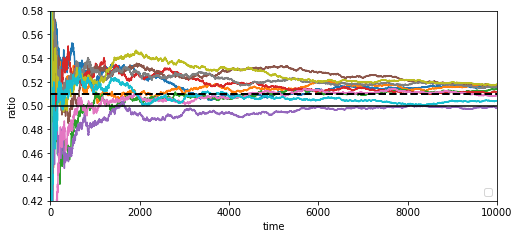

In [32]:
# 아래 그림은 균형이 틀어진 동전을 10번 실험한 그래프이다.
# 던진 횟수가 증가할 수록 앞면이 나올 확률 51%에 가까워진다.
# 결국, 10번의 실험 모두, 50% 보다 높게 유지되며 51%에 수렴하면서 끝나는것을 볼수 있다.

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(1,1,1)

heads_proba = 0.51

# 10번 던지기를 1만번 실험한것, 총 10만번 , 그중에 51퍼보다 작은것을 0,1로 표현
coin_tosses = (np.random.rand(10000,10) < heads_proba).astype(np.int32)

# np.cumsum는 배열 원소간 누적 합 구하기 범용함수 이다. 설명은 아래 셀
# 그걸 각각 원소에 1~10000 대입하여 나누어 준다. 그럼 마지막값은 10만번의 평균이 될것이다.
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0)/np.arange(1,10001).reshape(-1,1)

ax.plot(cumulative_heads_ratio)
ax.plot([0,10000],[0.51, 0.51],'k--', linewidth=2)
ax.plot([0,10000],[0.5, 0.5],'k-', )

plt.xlabel('time')
plt.ylabel('ratio')
ax.legend(loc = 'lower right')
ax.axis([0,10000, 0.42, 0.58])
plt.show()

In [18]:
a = np.array([[1,2,3],[4,5,6]])
print(np.cumsum(a))
print(np.cumsum(a, axis=0))
print(np.cumsum(a, axis=1))

[ 1  3  6 10 15 21]
[[1 2 3]
 [5 7 9]]
[[ 1  3  6]
 [ 4  9 15]]


이처럼, 무작위 추측보다 조금 더 나은 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다 가정.
가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있다. 하지만, 이런 가정은 모든 분류기가 완변하게 __독립__ 적이며, 오차의 상관관계가 없어야 한다. 하지만 여기서는 같은 데이터로 훈련시키기 때문에 가정이 맞지 않고, 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아진다.

앙상블 방법은, 예측기가 가능한 서로 독립적일 때 최고의 성능을 발휘한다.  
다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것,  
이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킬수 있다.  

In [35]:
# 아래는 여러 분류기를 조합하여, 사이킷 런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드이다.
# 훈련 세트는 moons 데이터 셋이다.

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [47]:
x, y = make_moons(n_samples = 500, noise = 0.30 , random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)], voting='hard')
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [48]:
# 각분류기의 테스트셋 정확도 확인하기

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf) :
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### 간접투표 (soft voting)

예상대로, 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음을 볼수 있다. 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측에 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 __간접 투표(soft voting)__ 라고 하고, 이방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표보다 성능이 높다.  
이 방식을 사용하기 위해서는 voting='soft' 로 바꾸고 모든 분류기가 클래스의 확률을 예측할 수 있으면 된다.

In [50]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
# SVM의 경우 기본값에서, 클래스의 확률을 제공하지 않으므로 probability=True 지정
svm_clf = SVC(gamma='auto', probability=True ,random_state=42)

voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)], voting='soft')
voting_clf.fit(x_train,y_train)

# 각분류기의 테스트셋 정확도 확인하기

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf) :
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912
